# Mask R-CNN - Train on Shapes Dataset


https://github.com/leekunhee/Mask_RCNN

https://github.com/ahmedfgad/Mask-RCNN-TF2

https://bitbucket.org/rewintous/isic_2018_mrcnn_submit/src/master/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#configurando o ambiente
!pip install -r "/content/drive/MyDrive/skin_cancer/models/mask_rcnn/requirements.txt"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.7/297.7 KB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 11.5 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.11.0
/device:GPU:0
Num GPUs Available:  1


In [4]:
# import packages
import numpy as np
import skimage.io
import argparse
import imutils
import random
import cv2
import os
import sys
from imutils import paths
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline

#initialize the dataset path, images path, and annotations file path
DATASET_PATH = os.path.abspath("/content/drive/MyDrive/skin_cancer/assets/img_dataset")

DATASET_IMAGES_PATH = os.path.sep.join([DATASET_PATH, "ISIC2018_Task1-2_Training_Input"])
DATASET_MASKS_PATH = os.path.sep.join([DATASET_PATH, "ISIC2018_Task1_Training_GroundTruth"])
DATASET_IMAGES = sorted(list(paths.list_images(DATASET_IMAGES_PATH)))

# TEST_IMAGES_PATH = os.path.sep.join([DATASET_PATH, "ISIC2018_Task1-2_Validation_Input"])
# TEST_MASKS_PATH = os.path.sep.join([DATASET_PATH, "ISIC2018_Task1_Validation_GroundTruth"])
# TEST_IMAGES = sorted(list(paths.list_images(TEST_IMAGES_PATH)))

#Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/skin_cancer/models/mask_rcnn")
sys.path.append(ROOT_DIR)  #To find local version of the library

from imgaug import augmenters as iaa
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn import utils

#initialize the class names dictionary
CLASS_NAMES = {1: "pigment network"}

#initialize the path to the Mask R-CNN pre-trained on COCO
COCO_PATH = "/content/drive/MyDrive/skin_cancer/models/mask_rcnn/weights/mask_rcnn_coco.h5"
# COCO_PATH = "/content/drive/MyDrive/skin_cancer/models/mask_rcnn/weights/lesion20230313T2032/mask_rcnn_lesion_0030.h5"

#initialize the name of the directory where logs and output model snapshots will be stored
LOGS_AND_MODEL_DIR = "/content/drive/MyDrive/skin_cancer/models/mask_rcnn/weights"

In [5]:
# initialize the amount of data to use for training
TRAINING_SPLIT = 0.90

idxs = list(range(0, len(DATASET_IMAGES[:400])))
random.seed(42)
random.shuffle(idxs)

i = int(len(idxs) * TRAINING_SPLIT)
train_idxs = idxs[:i]
val_idxs = idxs[i:]

print(len(train_idxs))
print(len(val_idxs))

360
40


In [6]:
TRAIN_COUNT = 2594
VALIDATION_COUNT = 300

## Configurations

In [7]:
class LesionBoundaryConfig(Config):
	#give the configuration a recognizable name
	NAME = "lesion"

	# set the number of GPUs to use training along with the number of
	# images per GPU (which may have to be tuned depending on how much memory your GPU has)
	GPU_COUNT = 1
	IMAGES_PER_GPU = 4

	# number of classes (+1 for the background)
	NUM_CLASSES = len(CLASS_NAMES) + 1

	# set the number of steps per training epoch and validation cycle
	STEPS_PER_EPOCH = (TRAIN_COUNT - VALIDATION_COUNT) // IMAGES_PER_GPU
	VALIDATION_STEPS = max(1, VALIDATION_COUNT // IMAGES_PER_GPU)
 
	# set the number of steps per training epoch and validation cycle
	# batch_size = GPU_COUNT * IMAGES_PER_GPU
	# STEPS_PER_EPOCH = len(train_idxs) // batch_size
	# VALIDATION_STEPS = len(val_idxs) // batch_size

	DETECTION_MIN_CONFIDENCE = 0

	# Backbone network architecture
	# Supported values are: resnet50, resnet101
	BACKBONE = "resnet50"

	# Input image resizing
	# Random crops of size 512x512 vs SQUARE 768 vs pad64 todo
	IMAGE_RESIZE_MODE = "square"
	IMAGE_MIN_DIM = 256 #800
	IMAGE_MAX_DIM = 256 #1024
	
	# Length of square anchor side in pixels
	# RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
	RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

	# ROIs kept after non-maximum supression (training and inference)
	POST_NMS_ROIS_TRAINING = 1000
	POST_NMS_ROIS_INFERENCE = 2000

	# Non-max suppression threshold to filter RPN proposals.
	# You can increase this during training to generate more propsals.
	RPN_NMS_THRESHOLD = 0.9

	# How many anchors per image to use for RPN training
	RPN_TRAIN_ANCHORS_PER_IMAGE = 64

	# Number of ROIs per image to feed to classifier/mask heads
	# The Mask RCNN paper uses 512 but often the RPN doesn't generate
	# enough positive proposals to fill this and keep a positive:negative
	# ratio of 1:3. You can increase the number of proposals by adjusting
	# the RPN NMS threshold.
	TRAIN_ROIS_PER_IMAGE = 128 #128

	# Maximum number of ground truth instances to use in one image
	MAX_GT_INSTANCES = 200

	# Max number of final detections per image
	DETECTION_MAX_INSTANCES = 400 #400

	# my configs
	# LEARNING_RATE = 0.01

	# If enabled, resizes instance masks to a smaller size to reduce
	# memory load. Recommended when using high-resolution images.
	USE_MINI_MASK = False
	MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

class LesionBoundaryInferenceConfig(LesionBoundaryConfig):
	#set the number of GPUs and images per GPU (which may be
	#different values than the ones used for training)
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
	RPN_NMS_THRESHOLD = 0.7

	# #set the minimum detection confidence (used to prune out false positive detections)
	# DETECTION_MIN_CONFIDENCE = 0.9

#initialize the training configuration
config = LesionBoundaryConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

## Dataset

In [8]:
# class LesionBoundaryDataset(utils.Dataset):
# 	def __init__(self, imagePaths, classNames):
# 		#call the parent constructor
# 		super().__init__(self)

# 		#store the image paths and class names along with the width we'll resize images to
# 		self.imagePaths = imagePaths
# 		self.classNames = classNames

# 	def load_lesions(self, idxs):
# 		#loop over all class names and add each to the 'lesion' dataset
# 		for (classID, label) in self.classNames.items():
# 			self.add_class("lesion", classID, label)

# 		#loop over the image path indexes
# 		for i in idxs:
# 			#extract the image filename to serve as the unique image ID
# 			imagePath = self.imagePaths[i]
# 			filename = imagePath.split(os.path.sep)[-1] #os.path.sep == "/"

# 			#add the image to the dataset
# 			self.add_image("lesion", image_id=filename,	path=imagePath)

# 	def load_mask(self, image_id):
# 		"""Generate instance masks for an image.
# 		Returns:
# 		masks: A bool array of shape [height, width, instance count] with
# 				one mask per instance.
# 		class_ids: a 1D array of class IDs of the instance masks.
# 		"""

# 		info = self.image_info[image_id]
# 		filename = info["id"].split(".")[0]

# 		masks = []
# 		for class_id in range(1,self.num_classes):
# 				mask_path = os.path.join(str(DATASET_MASKS_PATH), f"{filename}_segmentation.png")
# 				# Read mask files from .png image
# 				masks.append(skimage.io.imread(mask_path).astype(np.bool))
# 		# todo split input mask into several (connected) instances
# 		mask = np.stack(masks, axis=-1)
# 		# Return mask, and array of class IDs of each instance. Since we have
# 		# one class ID, we return an array of ones
# 		return mask, np.asarray(range(1,self.num_classes))

class LesionBoundaryDataset(utils.Dataset):
	def __init__(self, class_map=None, validation_count=VALIDATION_COUNT):
		super().__init__(class_map)
		self.ground_truth_dir = None
		self.validation_count = validation_count

	def load_skin(self, dataset_dir, ground_truth_dir, subset):
		"""Load a subset of the dataset.

		dataset_dir: Root directory of the dataset
		ground_truth_dir: Lesion Binary Masks (can be None)
		subset: one of:
						* train: stage1_train excluding validation images
						* val: validation images - for static random seed
						* all: all images from dataset_dir are used
		"""
		self.ground_truth_dir = ground_truth_dir
		# Add classes. We have one class.
		self.setup_classes()

		# Static random seed will be used here

		random.seed(42)
		jpg_files = [pth for pth in Path(dataset_dir).iterdir() if pth.suffix == '.jpg']

		# print(f"jpg_files {jpg_files}")
		# print(f"len jpg_files {len(jpg_files)}")

		training_set = random.sample(jpg_files, max(0, len(jpg_files) - self.validation_count))
		validation_set = list(set(jpg_files) - set(training_set))

		assert subset in ["train", "val", "all"]
		if subset == "val":
				image_paths = validation_set
		elif subset == "train":
				image_paths = training_set
		elif subset == "all":
				image_paths = sorted(jpg_files)
		else:
				image_paths = []

		# Add images
		for image_path in image_paths:
				split_names = os.path.split(str(image_path))
				fn, ext = os.path.splitext(split_names[-1])
				self.add_image(
						"skinroi",
						image_id=fn,
						path=str(image_path))
		 
	def setup_classes(self):
		self.add_class("skinroi", 1, "skinroi")

	def load_mask(self, image_id):
		"""Generate instance masks for an image.
		Returns:
		masks: A bool array of shape [height, width, instance count] with
				one mask per instance.
		class_ids: a 1D array of class IDs of the instance masks.
		"""

		info = self.image_info[image_id]
		masks = []
		for class_id in range(1,self.num_classes):
				mask_path = os.path.join(str(self.ground_truth_dir), self.format_mask_name(class_id, info))
				# Read mask files from .png image
				masks.append(skimage.io.imread(mask_path).astype(np.bool))
		# todo split input mask into several (connected) instances
		mask = np.stack(masks, axis=-1)
		# Return mask, and array of class IDs of each instance. Since we have
		# one class ID, we return an array of ones
		return mask, np.asarray(range(1,self.num_classes))
	
	def format_mask_name(self, class_id, info):
		return info['id'] + "_segmentation.png"

	def image_reference(self, image_id):
		"""Return the path of the image."""
		info = self.image_info[image_id]
		if info["source"] == "skinroi":
				return info["id"]
		else:
				super(self.__class__, self).image_reference(image_id)

In [9]:
# #load the training dataset
# dataset_train = LesionBoundaryDataset(DATASET_IMAGES, CLASS_NAMES)
# dataset_train.load_lesions(train_idxs)
# dataset_train.prepare()

# #load the validation dataset
# dataset_val = LesionBoundaryDataset(DATASET_IMAGES, CLASS_NAMES)
# dataset_val.load_lesions(val_idxs)
# dataset_val.prepare()

from pathlib import Path

#load the training dataset
dataset_train = LesionBoundaryDataset()
dataset_train.load_skin(DATASET_IMAGES_PATH, DATASET_MASKS_PATH, "train")
dataset_train.prepare()

#load the validation dataset
dataset_val = LesionBoundaryDataset()
dataset_val.load_skin(DATASET_IMAGES_PATH, DATASET_MASKS_PATH, "val")
dataset_val.prepare()

Investigating image index: 590


<ipython-input-8-25e5e6d8a0a8>:112: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masks.append(skimage.io.imread(mask_path).astype(np.bool))


image.shape (4441, 6641, 3)


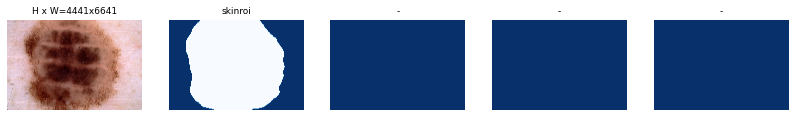

In [10]:
#determine a sample of training image indexes and loop over them
for i in np.random.choice(dataset_train.image_ids, 1):
  #load the image and masks for the sampled image
  print("Investigating image index: {}".format(i))
  image = dataset_train.load_image(i)
  (masks, classIDs) = dataset_train.load_mask(i)

  print(f"image.shape {image.shape}")

  #visualize the masks for the current image
  visualize.display_top_masks(image, masks, classIDs,	dataset_train.class_names)

Investigating image index: 261


<ipython-input-8-25e5e6d8a0a8>:112: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masks.append(skimage.io.imread(mask_path).astype(np.bool))


image.shape (768, 1024, 3)


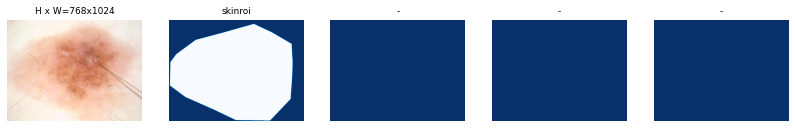

In [11]:
#determine a sample of training image indexes and loop over them
for i in np.random.choice(dataset_val.image_ids, 1):
  #load the image and masks for the sampled image
  print("Investigating image index: {}".format(i))
  image = dataset_val.load_image(i)
  (masks, classIDs) = dataset_val.load_mask(i)

  print(f"image.shape {image.shape}")

  #visualize the masks for the current image
  visualize.display_top_masks(image, masks, classIDs,	dataset_train.class_names)

## Create Model

In [12]:
# initialize the image augmentation process
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
aug = iaa.SomeOf((0, 2), [
  iaa.Fliplr(0.5),
  iaa.Flipud(0.5),
  iaa.OneOf(
    [
      iaa.Affine(rotate=90),
      iaa.Affine(rotate=180),
      iaa.Affine(rotate=270)
    ]
  ),
  iaa.Multiply((0.8, 1.5)),
  iaa.GaussianBlur(sigma=(0.0, 5.0))
])

#initialize the model and load the COCO weights so we can
#perform fine-tuning
model = modellib.MaskRCNN(mode="training", config=config, model_dir=LOGS_AND_MODEL_DIR)
model.load_weights(COCO_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Training

In [ ]:
import warnings
warnings.filterwarnings('ignore')

layers = "heads" #or "all"

if layers == "heads":
  #train *just* the layer heads
  model.train(
    dataset_train, dataset_val, epochs=15, layers="heads",
    learning_rate=config.LEARNING_RATE, augmentation=aug)
else:
  #unfreeze the body of the network and train *all* layers
  model.train(
    dataset_train, dataset_val, epochs=40, layers="all",
    learning_rate=config.LEARNING_RATE / 10, augmentation=aug)



Starting at epoch 0. LR=0.001

Checkpoint Path: ./mask_rcnn_lesion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrcnn_class_logits     (T

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join("/content/drive/MyDrive", "mask_rcnn_lesion_456.h5")
# model.keras_model.save_weights(model_path)

## Predict

In [ ]:
inference_config = LesionBoundaryInferenceConfig()

#initialize the Mask R-CNN model for inference
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=LOGS_AND_MODEL_DIR)

#load our trained Mask R-CNN
weights = model.find_last()
# weights = f"/content/drive/MyDrive/skin_cancer/models/mask_rcnn/mask_rcnn_lesion_0060.h5"

#load trained weights
print("Loading weights from ", weights)
model.load_weights(weights, by_name=True)

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

image_id = random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, config, image_id)
info = dataset_val.image_info[image_id]

print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, dataset_val.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'], verbose=1)

visualize.display_differences(
  image,
  gt_bbox, gt_class_id, gt_mask,
  r['rois'], r['class_ids'], r['scores'], r['masks'],
  dataset_val.class_names, ax=get_ax(),
  show_box=True, show_mask=True,
  iou_threshold=0.5, score_threshold=0.5
)

## Evaluation

## 0.0 defining the metrics

In [ ]:
def dice_coef(y_true, y_pred):
    intersec = y_true * y_pred
    union = y_true + y_pred
    if intersec.sum() == 0:
        dice_coef = 0
    else:
        dice_coef = round(intersec.sum() * 2 / union.sum(), 2)
    return dice_coef

In [ ]:
# from tqdm import tqdm

# #P @ IoU=0.5
# #Running on 10 images. Increase for better accuracy.
# #Metricas: Jaccard, precisão, Dice, especificidade, sensibilidade, acurácia (Métricas principais: Acurácia e Jaccard)

# image_ids = np.random.choice(dataset_val.image_ids, 100)
# ap_list = []
# precisions_list = []
# recalls_list = []
# overlaps_list = []
# dice_list = []

# for image_id in tqdm(image_ids):
#     #Load image and ground truth data
#     image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, image_id)
#     molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)

#     #Run object detection
#     # image = cv2.resize(image, (256, 256))
#     results = model.detect([image], verbose=0)
#     r = results[0]

#     #Compute AP
#     AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])

#     ap_list.append(AP)
#     precisions_list.append(precisions)
#     recalls_list.append(recalls)
#     overlaps_list.append(np.mean(overlaps))
    
# print("\n\nmAP: ", np.mean(ap_list))
# print("overlaps_mean: ", np.mean(overlaps_list))

In [ ]:
# #load the input image, convert it from BGR to RGB channel ordering, and resize the image
# image = cv2.imread("/content/drive/MyDrive/skin_cancer/assets/img_dataset/ISIC2018_Task1-2_Training_Input/ISIC_0000001.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# # image = cv2.resize(image, (512, 512))

# #perform a forward pass of the network to obtain the results
# r = model.detect([image], verbose=1)[0]

# #loop over of the detected object's bounding boxes and masks, drawing each as we go along
# for i in range(0, r["rois"].shape[0]):
#   mask = r["masks"][:, :, i]
#   image = visualize.apply_mask(image, mask, (1.0, 0.0, 0.0), alpha=0.5)
#   image = visualize.draw_box(image, r["rois"][i],	(1.0, 0.0, 0.0))

# #convert the image back to BGR so we can use OpenCV's drawing functions
# image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# #loop over the predicted scores and class labels
# for i in range(0, len(r["scores"])):
#   #extract the bounding box information, class ID, label and predicted probability from the results
#   (startY, startX, endY, end) = r["rois"][i]
#   classID = r["class_ids"][i]
#   label = CLASS_NAMES[classID]
#   score = r["scores"][i]

#   #draw the class label and score on the image
#   text = "{}: {:.4f}".format(label, score)
#   y = startY - 10 if startY - 10 > 10 else startY + 10
#   cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# #resize the image so it more easily fits on our screen
# # image = cv2.resize(image, (512, 512))

# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# #show the image with matplotlib
# plt.imshow(image)
# plt.show()

In [ ]:

	# def load_mask(self, image_id):
	# 	#grab the image info and derive the full annotation path file path
	# 	info = self.image_info[image_id]
	# 	filename = info["id"].split(".")[0]
	# 	annotPath = os.path.sep.join([DATASET_MASKS_PATH, f"{filename}_segmentation.png"])

	# 	#load the annotation mask and resize it, *making sure* to use nearest neighbor interpolation
	# 	annotMask = cv2.imread(annotPath)
	# 	annotMask = cv2.split(annotMask)[0]
	# 	# annotMask = imutils.resize(annotMask, width=self.width, inter=cv2.INTER_NEAREST)
	# 	# annotMask = cv2.resize(annotMask, (self.width, self.width))

	# 	annotMask[annotMask > 0] = 1

	# 	#determine the number of unique class labels in the mask
	# 	classIDs = np.unique(annotMask)
	# 	#the class ID with value '0' is actually the background which we should ignore and remove from the unique set of class identifiers
	# 	classIDs = np.delete(classIDs, [0])

	# 	#allocate memory for our [height, width, num_instances]
	# 	#array where each "instance" effectively has its own
	# 	#"channel" -- since there is only one lesion per image we
	# 	#know the number of instances is equal to 1
	# 	masks = np.zeros((annotMask.shape[0], annotMask.shape[1], 1),	dtype="uint8")

	# 	#loop over the class IDs
	# 	for (i, classID) in enumerate(classIDs):
	# 		#construct a mask for *only* the current label
	# 		classMask = np.zeros(annotMask.shape, dtype="uint8")
	# 		classMask[annotMask == classID] = 1

	# 		#store the class mask in the masks array
	# 		masks[:, :, i] = classMask

	# 	#return the mask array and class IDs
	# 	return (masks.astype("bool"), classIDs.astype("int32"))